In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
from collections import defaultdict

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


In [128]:
def correlation_plots(data, lags=None):
    '''
    Returns a lineplot of the raw data, 
    plots of the autocorrelation function and 
    partial autocorrelation function.
    '''
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [133]:
def train_val_test_split(data):
    # Creating 60-20-20 train-validation-test split
    size_train_test = int(len(data) * 0.9)
    train, test = data[:size_train_test], data[size_train_test:]
    size_train_val = int(len(train) * 8/9)
    train, val = train[:size_train_val], train[size_train_val:]
    print('Train:',len(train))
    print('Validation:',len(val))
    print('Test:',len(test))
    return train, val, test

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
def lstm_with_grid_search(train, val, n_steps_list=[24], batch_size_list=[128], epochs_list=[2]): # 16,32,128, ,10,20
    '''Trains model with specific hyper parameters through grid search
    and returns dictionary of hyperparameters as key and mse as value.
    Output:{(n_steps,batch_size,epochs,predictions,model): mse}
    '''
    lstm_grid_search_results = defaultdict(int)
    for n_steps in n_steps_list:
        for batch_size in batch_size_list:
            for epochs in epochs_list:
                print('Model with:','n_steps:',n_steps,'batch_size:',batch_size,'epochs:',epochs)
                # splitting into n length sequences
                X, y = split_sequence(train, n_steps)

                # reshape from [samples, timesteps] into [samples, timesteps, features]
                n_features = 1 # Series is univariate
                X = X.reshape((X.shape[0], X.shape[1], n_features))

                # Model Architecture
                model = Sequential()
                model.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features),return_sequences=False))
#                 model.add(Dropout(0.2, input_shape=(n_steps, n_features)))
#                 model.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features),return_sequences=False)) # return_sequences=True
#                 model.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features),return_sequences=False)) 
#                 model.add(Dropout(0.2, input_shape=(n_steps, n_features)))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')
                
                # fitting model
                model.fit(X, y, batch_size=batch_size, epochs=epochs)
                
                # Making predictions on validation set
                predictions = lstm_predictions(train, val, model, n_steps, n_features)
                
                # Calculating MSE
                mse = mean_squared_error(val[n_steps:],predictions) 
                print('Test MSE: %.3f' % mse)
                
                lstm_grid_search_results[(n_steps,batch_size,epochs,tuple(predictions),model)] = mse 
    return dict(lstm_grid_search_results)

In [6]:
def lstm_predictions(train, val, model, n_steps, n_features):
    predictions = []
    for i in range(len(val)-n_steps):
        x_input = np.array(val.values[i:i+n_steps])
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        predictions.append(yhat)
    return np.array(predictions).reshape((len(predictions)))

In [17]:
def Croston(ts,extra_periods=1,alpha=0.4):

    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods

    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation

    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]

    # Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1

    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]

    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})

    return df

In [286]:
def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.4):

    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods

    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)

# Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]

    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]

    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]

    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})

    return df

## Battalion 1 Modeling

In [143]:
# Unpickling battalion 1 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_1_30_min.pickle','wb') as f:
        pickle.dump(bat_1_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_1_30_min.pickle','rb') as f:
        bat_1 = pickle.load(f)

In [146]:
bat_1_train, bat_1_val, bat_1_test = train_val_test_split(bat_1)

Train: 268309
Validation: 33539
Test: 33539


### LSTM

In [159]:
bat_1_lstm_grid_search_results = lstm_with_grid_search(bat_1_train, bat_1_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268285/268285 [==============================] - 73s 271us/step - loss: 0.5470
Epoch 2/2
268285/268285 [==============================] - 66s 248us/step - loss: 0.5268
Test MSE: 0.804


In [ ]:
# Pickling bat_1_lstm_grid_search_results
redo_pickle = False

if redo_pickle == True:
    with open('bat_1_lstm_grid_search_results.pickle','wb') as f:
        pickle.dump(bat_1_lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('bat_1_lstm_grid_search_results.pickle','rb') as f:
        bat_1_lstm_grid_search_results = pickle.load(f)

In [173]:
# Hyperparameters of model with lowest mse
bat_1_best_hyperparameters = min(bat_1_lstm_grid_search_results, key=bat_1_lstm_grid_search_results.get)

In [174]:
# RMSE of best model
np.sqrt(bat_1_lstm_grid_search_results[bat_1_best_hyperparameters])

0.8968221986090329

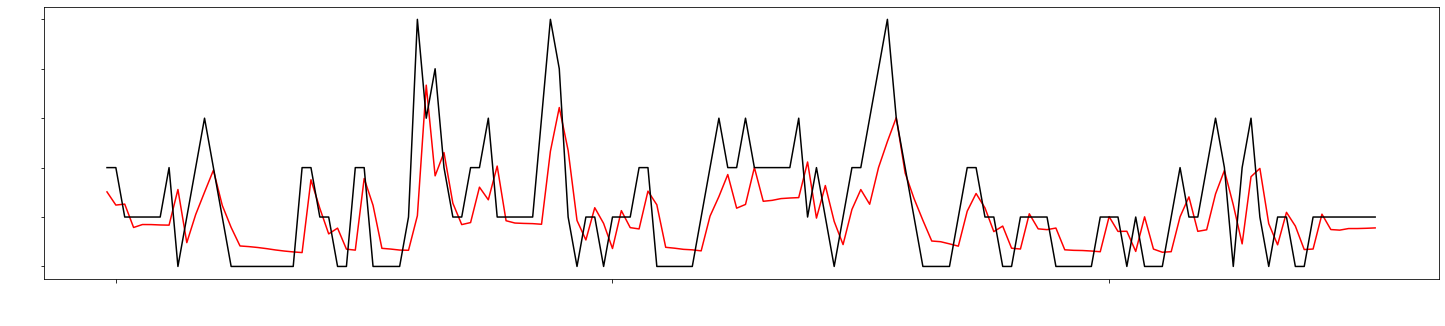

In [125]:
# Plotting predictions vs actual of best model
bat_1_predictions = pd.to_numeric(min(bat_1_lstm_grid_search_results, key=bat_1_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_1_predictions[:2*24*3],color='red')
plt.plot(bat_1_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Croston Method

In [287]:
bat_1_train_and_val = bat_1_train.append(bat_1_val)

In [375]:
bat_1_croston_tsb = Croston_TSB(bat_1_val)

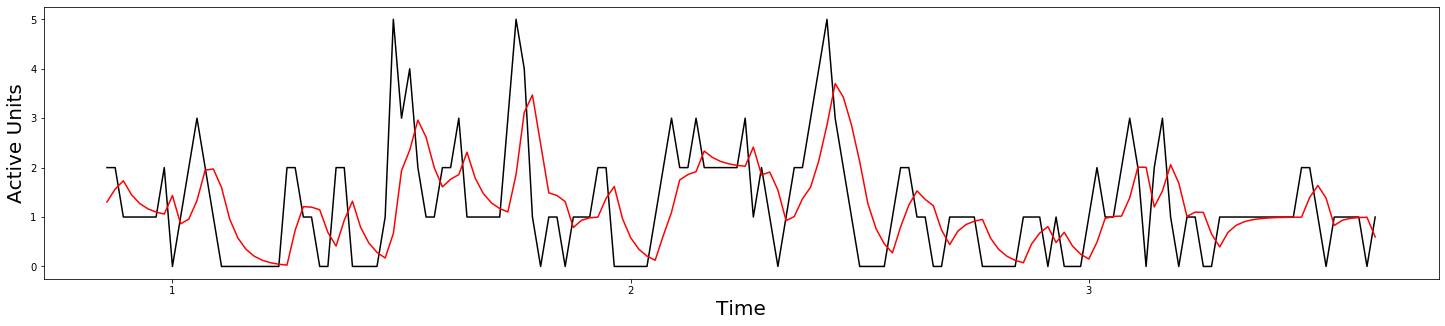

In [376]:
# Plotting predictions vs actual of croston model  (used #FFFFFF for presentation colors)

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_1_croston_tsb.iloc[12:24+(2*24*3),0],color='black')
sns.lineplot(data=bat_1_croston_tsb.iloc[12:24+(2*24*3),1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='black')
plt.yticks(color='black')
plt.xlabel('Time',fontsize = 20, color='black')
plt.ylabel('Active Units', fontsize = 20, color='black');

In [377]:
bat_1_croston_tsb.fillna(0, inplace=True)

In [378]:
# Calculating MSE of croston
np.sqrt(mean_squared_error(bat_1_croston_tsb.loc[:,'Demand'], bat_1_croston_tsb.loc[:,'Forecast']) )

1.0364986004392471

## Battalion 2 Modeling

In [231]:
# Unpickling battalion 2 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_2_30_min.pickle','wb') as f:
        pickle.dump(bat_2_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_2_30_min.pickle','rb') as f:
        bat_2 = pickle.load(f)

In [232]:
bat_2_train, bat_2_val, bat_2_test = train_val_test_split(bat_2)

Train: 268309
Validation: 33539
Test: 33539


### LSTM

In [243]:
bat_2_lstm_grid_search_results = lstm_with_grid_search(bat_2_train, bat_2_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268285/268285 [==============================] - 56s 209us/step - loss: 1.7698
Epoch 2/2
268285/268285 [==============================] - 61s 228us/step - loss: 1.6523
Test MSE: 2.828


In [ ]:
# Pickling bat_2_lstm_grid_search_results
redo_pickle = False

if redo_pickle == True:
    with open('bat_2_lstm_grid_search_results.pickle','wb') as f:
        pickle.dump(bat_2_lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('bat_2_lstm_grid_search_results.pickle','rb') as f:
        bat_2_lstm_grid_search_results = pickle.load(f)

In [244]:
# Hyperparameters of model with lowest mse
bat_2_best_hyperparameters = min(bat_2_lstm_grid_search_results, key=bat_2_lstm_grid_search_results.get)

In [245]:
# RMSE of best model
np.sqrt(bat_2_lstm_grid_search_results[bat_2_best_hyperparameters])

1.6815304306738963

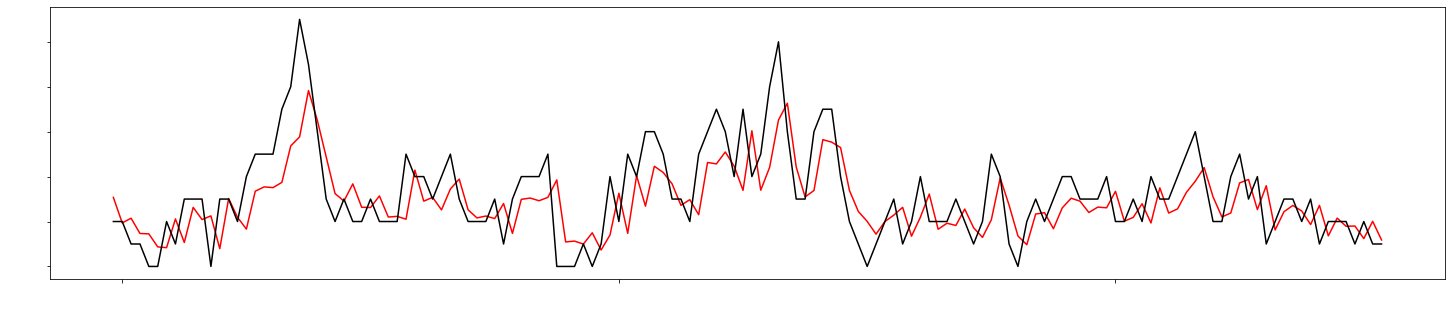

In [246]:
# Plotting predictions vs actual of best model
bat_2_predictions = pd.to_numeric(min(bat_2_lstm_grid_search_results, key=bat_2_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_2_predictions[:2*24*3],color='red')
plt.plot(bat_2_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Croston Method

In [296]:
# Combining Train and Validation for croston algorithm
bat_2_train_and_val = bat_2_train.append(bat_2_val)

In [371]:
bat_2_croston_tsb = Croston_TSB(bat_2_val)

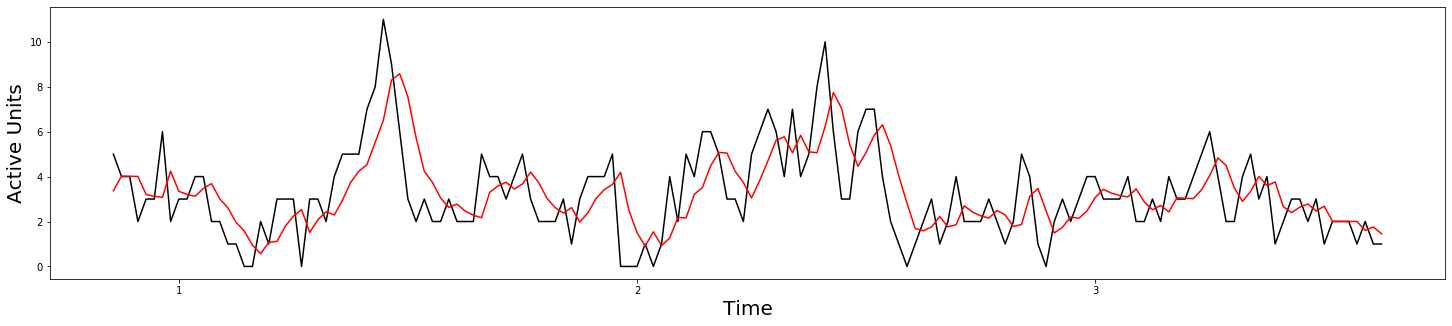

In [372]:
# Plotting predictions vs actual of croston model  (used #FFFFFF for presentation colors)

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_2_croston_tsb.iloc[12:24+(2*24*3),0],color='black')
sns.lineplot(data=bat_2_croston_tsb.iloc[12:24+(2*24*3),1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='black')
plt.yticks(color='black')
plt.xlabel('Time',fontsize = 20, color='black')
plt.ylabel('Active Units', fontsize = 20, color='black');

In [373]:
bat_2_croston_tsb.fillna(0, inplace=True)


In [374]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_2_croston_tsb.loc[:,'Demand'], bat_2_croston_tsb.loc[:,'Forecast']) )

1.8467355246452466

## Battalion 3 Modeling

In [301]:
# Unpickling battalion 3 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_3_30_min.pickle','wb') as f:
        pickle.dump(bat_3_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_3_30_min.pickle','rb') as f:
        bat_3 = pickle.load(f)

In [302]:
bat_3_train, bat_3_val, bat_3_test = train_val_test_split(bat_3)

Train: 268309
Validation: 33539
Test: 33539


### LSTM

In [366]:
bat_3_lstm_grid_search_results = lstm_with_grid_search(bat_3_train, bat_3_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268285/268285 [==============================] - 48s 181us/step - loss: 0.4820
Epoch 2/2
268285/268285 [==============================] - 53s 199us/step - loss: 0.4617
Test MSE: 0.930


In [368]:
# Pickling bat_3_lstm_grid_search_results
redo_pickle = True

if redo_pickle == True:
    with open('bat_3_lstm_grid_search_results.pickle','wb') as f:
        pickle.dump(bat_3_lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('bat_3_lstm_grid_search_results.pickle','rb') as f:
        bat_3_lstm_grid_search_results = pickle.load(f)

TypeError: can't pickle _thread.RLock objects

In [369]:
# Hyperparameters of model with lowest mse
bat_3_best_hyperparameters = min(bat_3_lstm_grid_search_results, key=bat_3_lstm_grid_search_results.get)

In [370]:
# RMSE of best model
np.sqrt(bat_3_lstm_grid_search_results[bat_3_best_hyperparameters])

0.9643303945297345

In [ ]:
# Plotting predictions vs actual of best model
bat_3_predictions = pd.to_numeric(min(bat_3_lstm_grid_search_results, key=bat_3_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_3_predictions[:2*24*3],color='red')
plt.plot(bat_3_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Croston Method

In [303]:
# Combining Train and Validation for croston algorithm
bat_3_train_and_val = bat_3_train.append(bat_3_val)

In [313]:
bat_3_croston_tsb = Croston_TSB(bat_3_train_and_val)

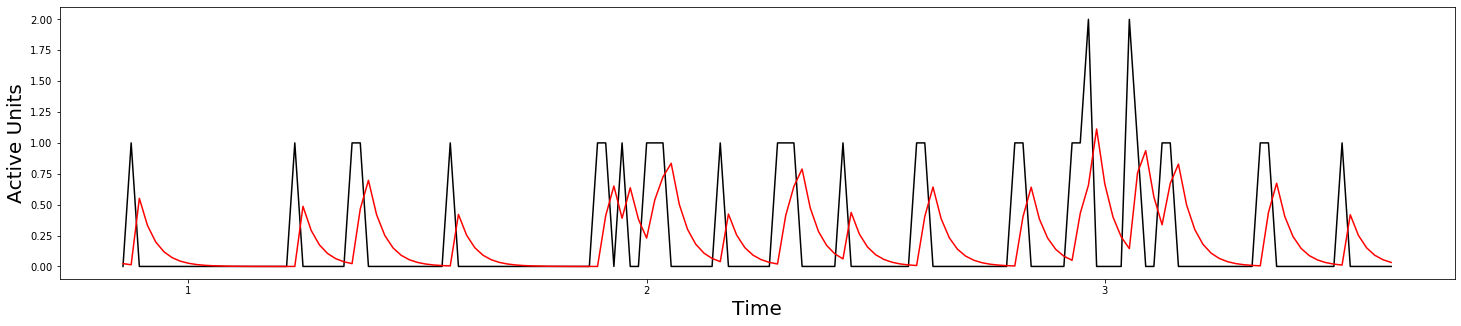

In [314]:
# Plotting predictions vs actual of croston model  (used #FFFFFF for presentation colors)

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_3_croston_tsb.iloc[12:24+(2*24*3),0],color='black')
sns.lineplot(data=bat_3_croston_tsb.iloc[12:24+(2*24*3),1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='black')
plt.yticks(color='black')
plt.xlabel('Time',fontsize = 20, color='black')
plt.ylabel('Active Units', fontsize = 20, color='black');

In [315]:
bat_3_croston_tsb.fillna(0, inplace=True)


In [316]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_3_croston_tsb.loc[:,'Demand'], bat_3_croston_tsb.loc[:,'Forecast']) )

0.8049605092264066

## Battalion 4 Modeling

In [317]:
# Unpickling battalion 4 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_4_30_min.pickle','wb') as f:
        pickle.dump(bat_4_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_4_30_min.pickle','rb') as f:
        bat_4 = pickle.load(f)

In [318]:
bat_4_train, bat_4_val, bat_4_test = train_val_test_split(bat_4)

Train: 268309
Validation: 33539
Test: 33539


### LSTM

In [243]:
bat_4_lstm_grid_search_results = lstm_with_grid_search(bat_4_train, bat_4_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268285/268285 [==============================] - 56s 209us/step - loss: 1.7698
Epoch 2/2
268285/268285 [==============================] - 61s 228us/step - loss: 1.6523
Test MSE: 2.828


In [ ]:
# Pickling bat_4_lstm_grid_search_results
redo_pickle = False

if redo_pickle == True:
    with open('bat_4_lstm_grid_search_results.pickle','wb') as f:
        pickle.dump(bat_4_lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('bat_4_lstm_grid_search_results.pickle','rb') as f:
        bat_4_lstm_grid_search_results = pickle.load(f)

In [244]:
# Hyperparameters of model with lowest mse
bat_4_best_hyperparameters = min(bat_4_lstm_grid_search_results, key=bat_4_lstm_grid_search_results.get)

In [245]:
# RMSE of best model
np.sqrt(bat_4_lstm_grid_search_results[bat_4_best_hyperparameters])

1.6815304306738963

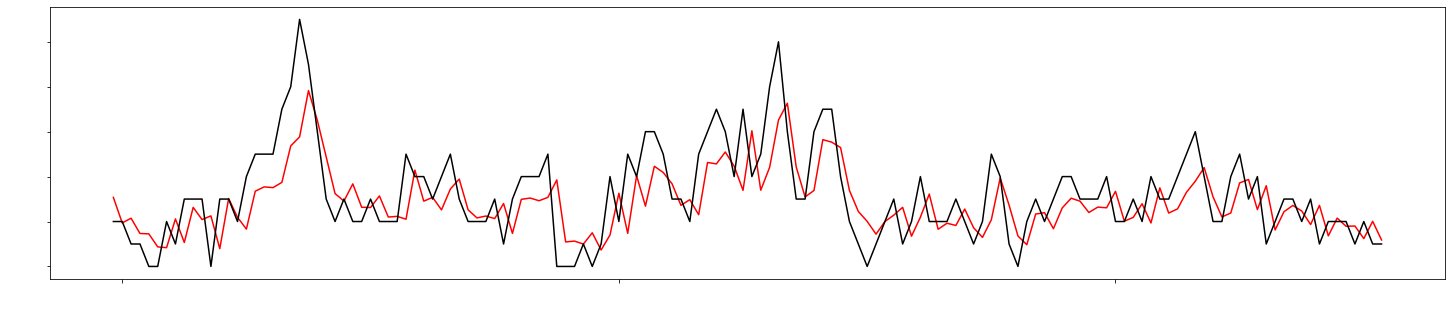

In [246]:
# Plotting predictions vs actual of best model
bat_4_predictions = pd.to_numeric(min(bat_4_lstm_grid_search_results, key=bat_4_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_4_predictions[:2*24*3],color='red')
plt.plot(bat_4_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Croston Method

In [319]:
# Combining Train and Validation for croston algorithm
bat_4_train_and_val = bat_4_train.append(bat_4_val)

In [320]:
bat_4_croston_tsb = Croston_TSB(bat_4_train_and_val)

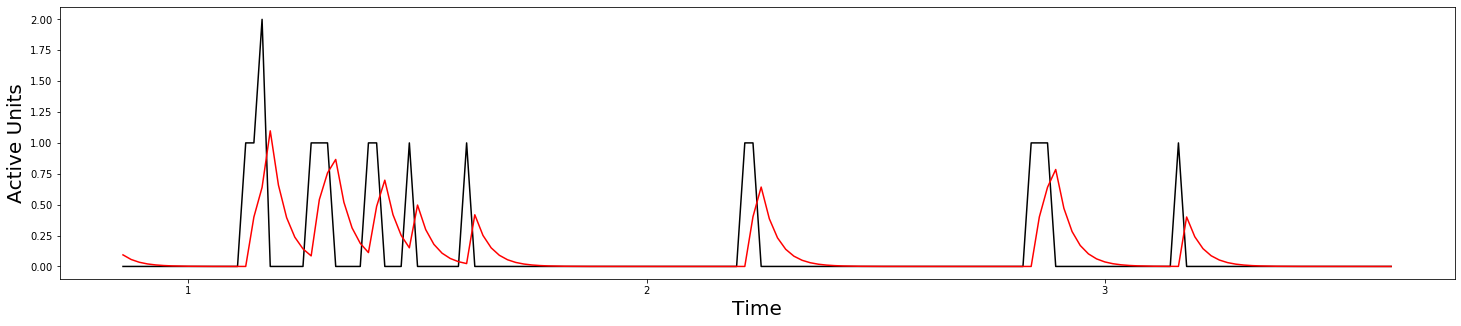

In [321]:
# Plotting predictions vs actual of croston model  (used #FFFFFF for presentation colors)

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_4_croston_tsb.iloc[12:24+(2*24*3),0],color='black')
sns.lineplot(data=bat_4_croston_tsb.iloc[12:24+(2*24*3),1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='black')
plt.yticks(color='black')
plt.xlabel('Time',fontsize = 20, color='black')
plt.ylabel('Active Units', fontsize = 20, color='black');

In [322]:
bat_4_croston_tsb.fillna(0, inplace=True)


In [323]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_4_croston_tsb.loc[:,'Demand'], bat_4_croston_tsb.loc[:,'Forecast']) )

0.6037151571020779

## Battalion 5 Modeling

In [324]:
# Unpickling battalion 5 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_5_30_min.pickle','wb') as f:
        pickle.dump(bat_5_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_5_30_min.pickle','rb') as f:
        bat_5 = pickle.load(f)

In [325]:
bat_5_train, bat_5_val, bat_5_test = train_val_test_split(bat_5)

Train: 268309
Validation: 33539
Test: 33539


### LSTM

In [243]:
bat_5_lstm_grid_search_results = lstm_with_grid_search(bat_5_train, bat_5_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268285/268285 [==============================] - 56s 209us/step - loss: 1.7698
Epoch 2/2
268285/268285 [==============================] - 61s 228us/step - loss: 1.6523
Test MSE: 2.828


In [ ]:
# Pickling bat_5_lstm_grid_search_results
redo_pickle = False

if redo_pickle == True:
    with open('bat_5_lstm_grid_search_results.pickle','wb') as f:
        pickle.dump(bat_5_lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('bat_5_lstm_grid_search_results.pickle','rb') as f:
        bat_5_lstm_grid_search_results = pickle.load(f)

In [244]:
# Hyperparameters of model with lowest mse
bat_5_best_hyperparameters = min(bat_5_lstm_grid_search_results, key=bat_5_lstm_grid_search_results.get)

In [245]:
# RMSE of best model
np.sqrt(bat_5_lstm_grid_search_results[bat_5_best_hyperparameters])

1.6815304306738963

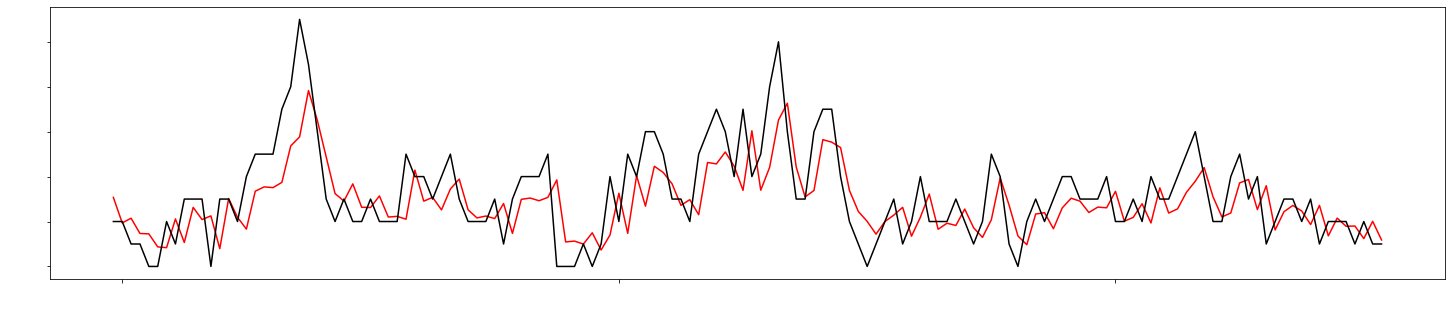

In [246]:
# Plotting predictions vs actual of best model
bat_5_predictions = pd.to_numeric(min(bat_5_lstm_grid_search_results, key=bat_5_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_5_predictions[:2*24*3],color='red')
plt.plot(bat_5_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Croston Method

In [326]:
# Combining Train and Validation for croston algorithm
bat_5_train_and_val = bat_5_train.append(bat_5_val)

In [327]:
bat_5_croston_tsb = Croston_TSB(bat_5_train_and_val)

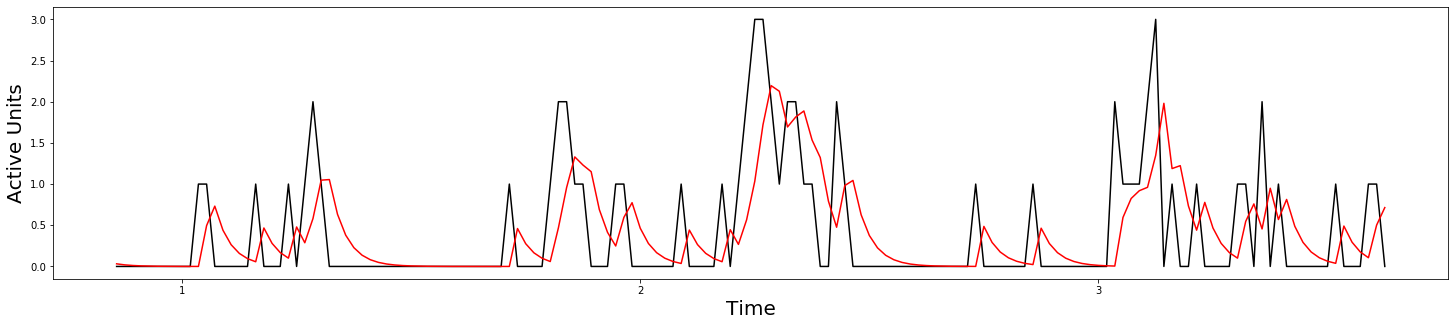

In [328]:
# Plotting predictions vs actual of croston model  (used #FFFFFF for presentation colors)

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_5_croston_tsb.iloc[12:24+(2*24*3),0],color='black')
sns.lineplot(data=bat_5_croston_tsb.iloc[12:24+(2*24*3),1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='black')
plt.yticks(color='black')
plt.xlabel('Time',fontsize = 20, color='black')
plt.ylabel('Active Units', fontsize = 20, color='black');

In [329]:
bat_5_croston_tsb.fillna(0, inplace=True)


In [330]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_5_croston_tsb.loc[:,'Demand'], bat_5_croston_tsb.loc[:,'Forecast']) )

0.9024378691334505

## Battalion 6 Modeling

In [331]:
# Unpickling battalion 6 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_6_30_min.pickle','wb') as f:
        pickle.dump(bat_6_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_6_30_min.pickle','rb') as f:
        bat_6 = pickle.load(f)

In [332]:
bat_6_train, bat_6_val, bat_6_test = train_val_test_split(bat_6)

Train: 268309
Validation: 33539
Test: 33539


### LSTM

In [243]:
bat_6_lstm_grid_search_results = lstm_with_grid_search(bat_6_train, bat_6_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268285/268285 [==============================] - 56s 209us/step - loss: 1.7698
Epoch 2/2
268285/268285 [==============================] - 61s 228us/step - loss: 1.6523
Test MSE: 2.828


In [ ]:
# Pickling bat_6_lstm_grid_search_results
redo_pickle = False

if redo_pickle == True:
    with open('bat_6_lstm_grid_search_results.pickle','wb') as f:
        pickle.dump(bat_6_lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('bat_6_lstm_grid_search_results.pickle','rb') as f:
        bat_6_lstm_grid_search_results = pickle.load(f)

In [244]:
# Hyperparameters of model with lowest mse
bat_6_best_hyperparameters = min(bat_6_lstm_grid_search_results, key=bat_6_lstm_grid_search_results.get)

In [245]:
# RMSE of best model
np.sqrt(bat_6_lstm_grid_search_results[bat_6_best_hyperparameters])

1.6815304306738963

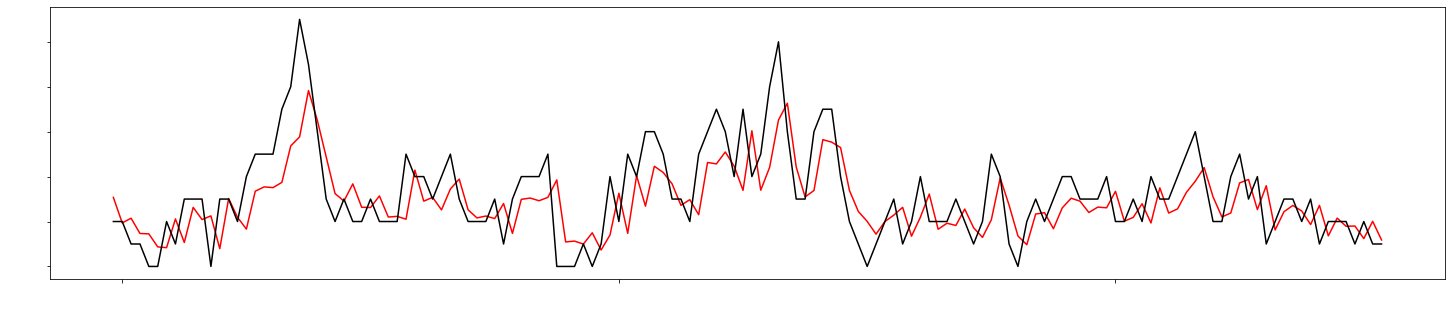

In [246]:
# Plotting predictions vs actual of best model
bat_6_predictions = pd.to_numeric(min(bat_6_lstm_grid_search_results, key=bat_6_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_6_predictions[:2*24*3],color='red')
plt.plot(bat_6_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Croston Method

In [333]:
# Combining Train and Validation for croston algorithm
bat_6_train_and_val = bat_6_train.append(bat_6_val)

In [334]:
bat_6_croston_tsb = Croston_TSB(bat_6_train_and_val)

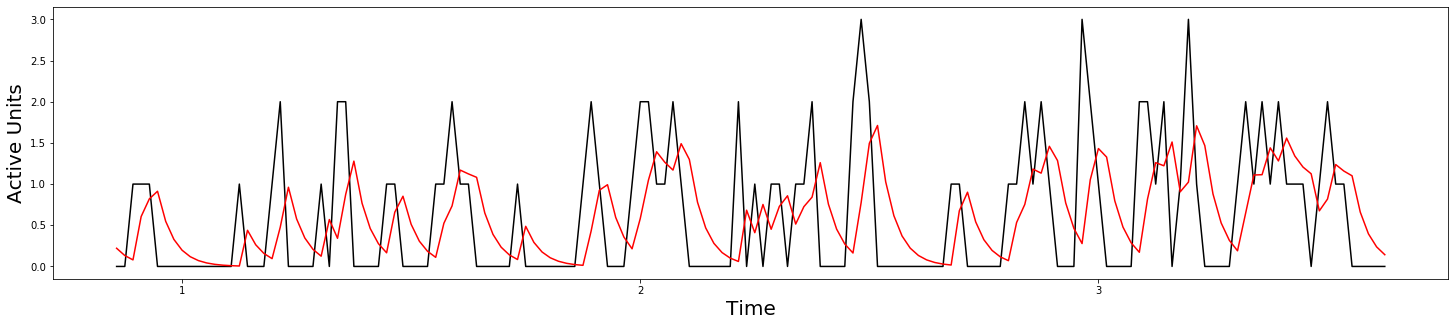

In [335]:
# Plotting predictions vs actual of croston model  (used #FFFFFF for presentation colors)

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_6_croston_tsb.iloc[12:24+(2*24*3),0],color='black')
sns.lineplot(data=bat_6_croston_tsb.iloc[12:24+(2*24*3),1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='black')
plt.yticks(color='black')
plt.xlabel('Time',fontsize = 20, color='black')
plt.ylabel('Active Units', fontsize = 20, color='black');

In [336]:
bat_6_croston_tsb.fillna(0, inplace=True)


In [337]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_6_croston_tsb.loc[:,'Demand'], bat_6_croston_tsb.loc[:,'Forecast']) )

1.1321973440762638

## Battalion 7 Modeling

In [338]:
# Unpickling battalion 7 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_7_30_min.pickle','wb') as f:
        pickle.dump(bat_7_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_7_30_min.pickle','rb') as f:
        bat_7 = pickle.load(f)

In [339]:
bat_7_train, bat_7_val, bat_7_test = train_val_test_split(bat_7)

Train: 268309
Validation: 33539
Test: 33539


### LSTM

In [243]:
bat_7_lstm_grid_search_results = lstm_with_grid_search(bat_7_train, bat_7_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268285/268285 [==============================] - 56s 209us/step - loss: 1.7698
Epoch 2/2
268285/268285 [==============================] - 61s 228us/step - loss: 1.6523
Test MSE: 2.828


In [ ]:
# Pickling bat_7_lstm_grid_search_results
redo_pickle = False

if redo_pickle == True:
    with open('bat_7_lstm_grid_search_results.pickle','wb') as f:
        pickle.dump(bat_7_lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('bat_7_lstm_grid_search_results.pickle','rb') as f:
        bat_7_lstm_grid_search_results = pickle.load(f)

In [244]:
# Hyperparameters of model with lowest mse
bat_7_best_hyperparameters = min(bat_7_lstm_grid_search_results, key=bat_7_lstm_grid_search_results.get)

In [245]:
# RMSE of best model
np.sqrt(bat_7_lstm_grid_search_results[bat_7_best_hyperparameters])

1.6815304306738963

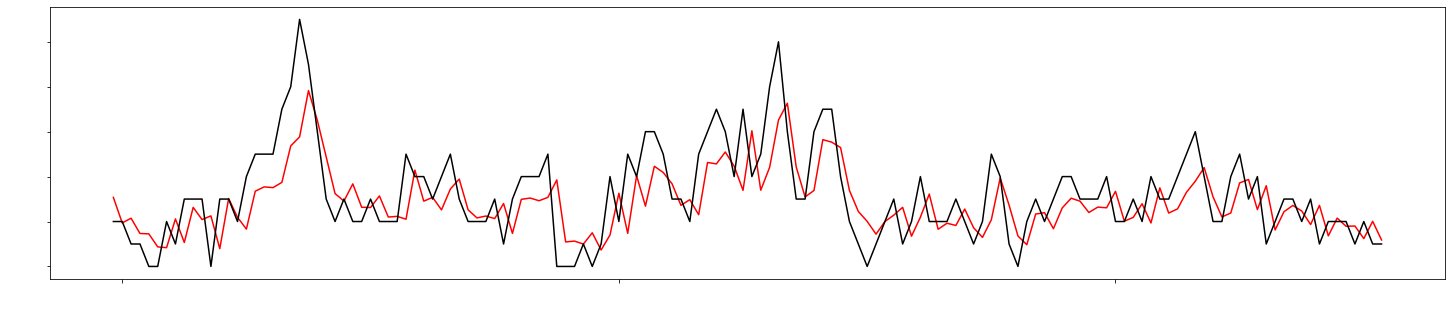

In [246]:
# Plotting predictions vs actual of best model
bat_7_predictions = pd.to_numeric(min(bat_7_lstm_grid_search_results, key=bat_7_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_7_predictions[:2*24*3],color='red')
plt.plot(bat_7_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Croston Method

In [340]:
# Combining Train and Validation for croston algorithm
bat_7_train_and_val = bat_7_train.append(bat_7_val)

In [341]:
bat_7_croston_tsb = Croston_TSB(bat_7_train_and_val)

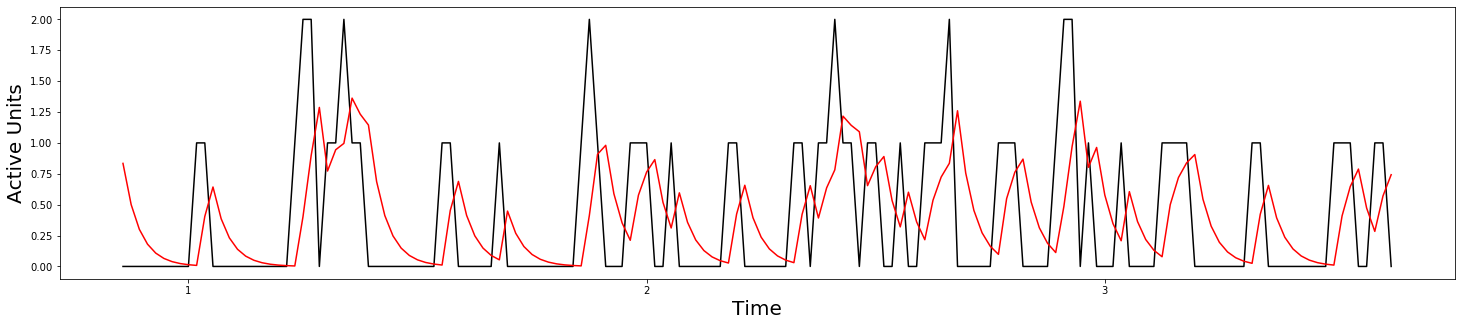

In [342]:
# Plotting predictions vs actual of croston model  (used #FFFFFF for presentation colors)

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_7_croston_tsb.iloc[12:24+(2*24*3),0],color='black')
sns.lineplot(data=bat_7_croston_tsb.iloc[12:24+(2*24*3),1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='black')
plt.yticks(color='black')
plt.xlabel('Time',fontsize = 20, color='black')
plt.ylabel('Active Units', fontsize = 20, color='black');

In [343]:
bat_7_croston_tsb.fillna(0, inplace=True)


In [344]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_7_croston_tsb.loc[:,'Demand'], bat_7_croston_tsb.loc[:,'Forecast']) )

0.6579247316082415

## Battalion 8 Modeling

In [345]:
# Unpickling battalion 8 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_8_30_min.pickle','wb') as f:
        pickle.dump(bat_8_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_8_30_min.pickle','rb') as f:
        bat_8 = pickle.load(f)

In [346]:
bat_8_train, bat_8_val, bat_8_test = train_val_test_split(bat_8)

Train: 268309
Validation: 33539
Test: 33539


### LSTM

In [243]:
bat_8_lstm_grid_search_results = lstm_with_grid_search(bat_8_train, bat_8_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268285/268285 [==============================] - 56s 209us/step - loss: 1.7698
Epoch 2/2
268285/268285 [==============================] - 61s 228us/step - loss: 1.6523
Test MSE: 2.828


In [ ]:
# Pickling bat_8_lstm_grid_search_results
redo_pickle = False

if redo_pickle == True:
    with open('bat_8_lstm_grid_search_results.pickle','wb') as f:
        pickle.dump(bat_8_lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('bat_8_lstm_grid_search_results.pickle','rb') as f:
        bat_8_lstm_grid_search_results = pickle.load(f)

In [244]:
# Hyperparameters of model with lowest mse
bat_8_best_hyperparameters = min(bat_8_lstm_grid_search_results, key=bat_8_lstm_grid_search_results.get)

In [245]:
# RMSE of best model
np.sqrt(bat_8_lstm_grid_search_results[bat_8_best_hyperparameters])

1.6815304306738963

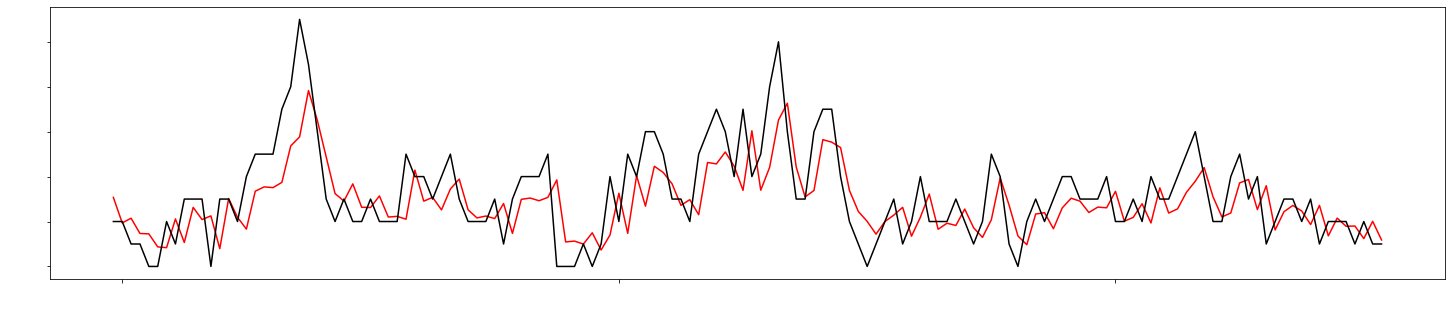

In [246]:
# Plotting predictions vs actual of best model
bat_8_predictions = pd.to_numeric(min(bat_8_lstm_grid_search_results, key=bat_8_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_8_predictions[:2*24*3],color='red')
plt.plot(bat_8_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Croston Method

In [347]:
# Combining Train and Validation for croston algorithm
bat_8_train_and_val = bat_8_train.append(bat_8_val)

In [348]:
bat_8_croston_tsb = Croston_TSB(bat_8_train_and_val)

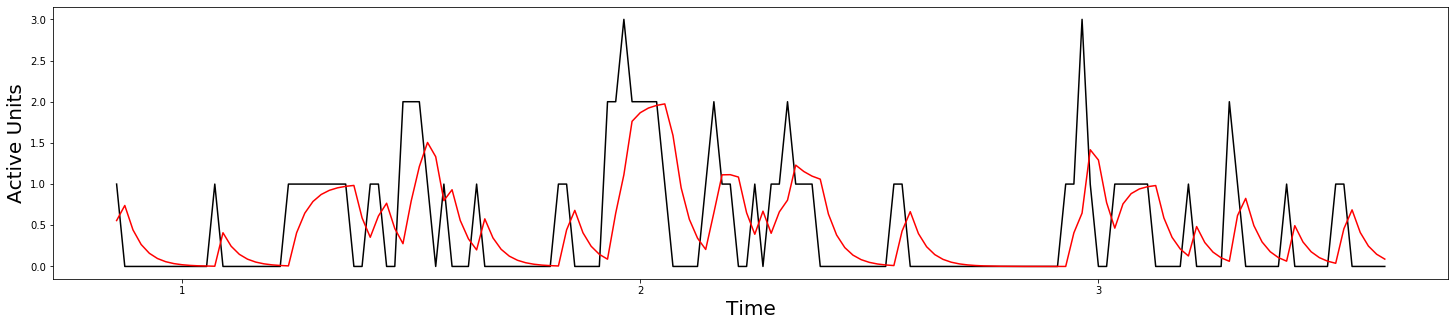

In [349]:
# Plotting predictions vs actual of croston model  (used #FFFFFF for presentation colors)

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_8_croston_tsb.iloc[12:24+(2*24*3),0],color='black')
sns.lineplot(data=bat_8_croston_tsb.iloc[12:24+(2*24*3),1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='black')
plt.yticks(color='black')
plt.xlabel('Time',fontsize = 20, color='black')
plt.ylabel('Active Units', fontsize = 20, color='black');

In [350]:
bat_8_croston_tsb.fillna(0, inplace=True)


In [351]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_8_croston_tsb.loc[:,'Demand'], bat_8_croston_tsb.loc[:,'Forecast']) )

0.8293123666323535

## Battalion 9 Modeling

In [352]:
# Unpickling battalion 9 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_9_30_min.pickle','wb') as f:
        pickle.dump(bat_9_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_9_30_min.pickle','rb') as f:
        bat_9 = pickle.load(f)

In [353]:
bat_9_train, bat_9_val, bat_9_test = train_val_test_split(bat_9)

Train: 268309
Validation: 33539
Test: 33539


### LSTM

In [243]:
bat_9_lstm_grid_search_results = lstm_with_grid_search(bat_9_train, bat_9_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268285/268285 [==============================] - 56s 209us/step - loss: 1.7698
Epoch 2/2
268285/268285 [==============================] - 61s 228us/step - loss: 1.6523
Test MSE: 2.828


In [ ]:
# Pickling bat_9_lstm_grid_search_results
redo_pickle = False

if redo_pickle == True:
    with open('bat_9_lstm_grid_search_results.pickle','wb') as f:
        pickle.dump(bat_9_lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('bat_9_lstm_grid_search_results.pickle','rb') as f:
        bat_9_lstm_grid_search_results = pickle.load(f)

In [244]:
# Hyperparameters of model with lowest mse
bat_9_best_hyperparameters = min(bat_9_lstm_grid_search_results, key=bat_9_lstm_grid_search_results.get)

In [245]:
# RMSE of best model
np.sqrt(bat_9_lstm_grid_search_results[bat_9_best_hyperparameters])

1.6815304306738963

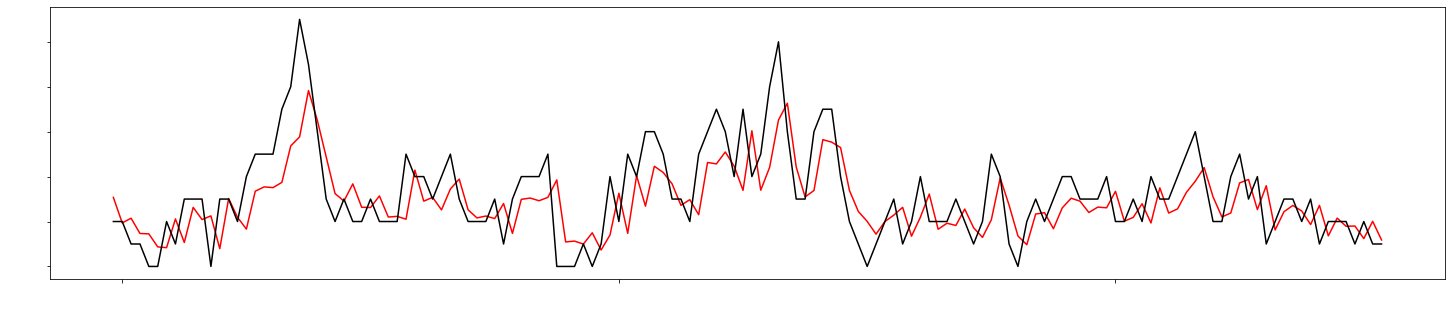

In [246]:
# Plotting predictions vs actual of best model
bat_9_predictions = pd.to_numeric(min(bat_9_lstm_grid_search_results, key=bat_9_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_9_predictions[:2*24*3],color='red')
plt.plot(bat_9_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Croston Method

In [354]:
# Combining Train and Validation for croston algorithm
bat_9_train_and_val = bat_9_train.append(bat_9_val)

In [355]:
bat_9_croston_tsb = Croston_TSB(bat_9_train_and_val)

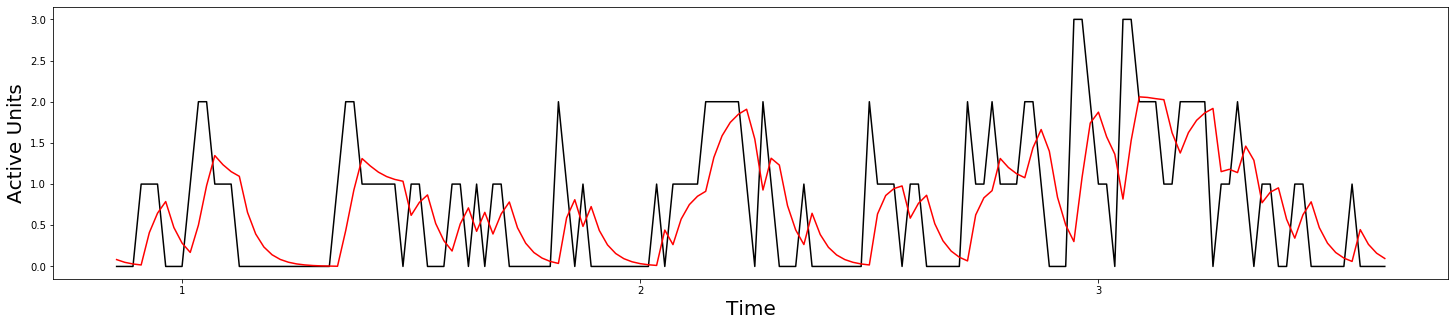

In [356]:
# Plotting predictions vs actual of croston model  (used #FFFFFF for presentation colors)

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_9_croston_tsb.iloc[12:24+(2*24*3),0],color='black')
sns.lineplot(data=bat_9_croston_tsb.iloc[12:24+(2*24*3),1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='black')
plt.yticks(color='black')
plt.xlabel('Time',fontsize = 20, color='black')
plt.ylabel('Active Units', fontsize = 20, color='black');

In [357]:
bat_9_croston_tsb.fillna(0, inplace=True)


In [358]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_9_croston_tsb.loc[:,'Demand'], bat_9_croston_tsb.loc[:,'Forecast']) )

0.956963340305289

## Battalion 10 Modeling

In [359]:
# Unpickling battalion 10 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_10_30_min.pickle','wb') as f:
        pickle.dump(bat_10_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_10_30_min.pickle','rb') as f:
        bat_10 = pickle.load(f)

In [360]:
bat_10_train, bat_10_val, bat_10_test = train_val_test_split(bat_10)

Train: 268309
Validation: 33539
Test: 33539


### LSTM

In [243]:
bat_10_lstm_grid_search_results = lstm_with_grid_search(bat_10_train, bat_10_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268285/268285 [==============================] - 56s 209us/step - loss: 1.7698
Epoch 2/2
268285/268285 [==============================] - 61s 228us/step - loss: 1.6523
Test MSE: 2.828


In [ ]:
# Pickling bat_10_lstm_grid_search_results
redo_pickle = False

if redo_pickle == True:
    with open('bat_10_lstm_grid_search_results.pickle','wb') as f:
        pickle.dump(bat_10_lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('bat_10_lstm_grid_search_results.pickle','rb') as f:
        bat_10_lstm_grid_search_results = pickle.load(f)

In [244]:
# Hyperparameters of model with lowest mse
bat_10_best_hyperparameters = min(bat_10_lstm_grid_search_results, key=bat_10_lstm_grid_search_results.get)

In [245]:
# RMSE of best model
np.sqrt(bat_10_lstm_grid_search_results[bat_10_best_hyperparameters])

1.6815304306738963

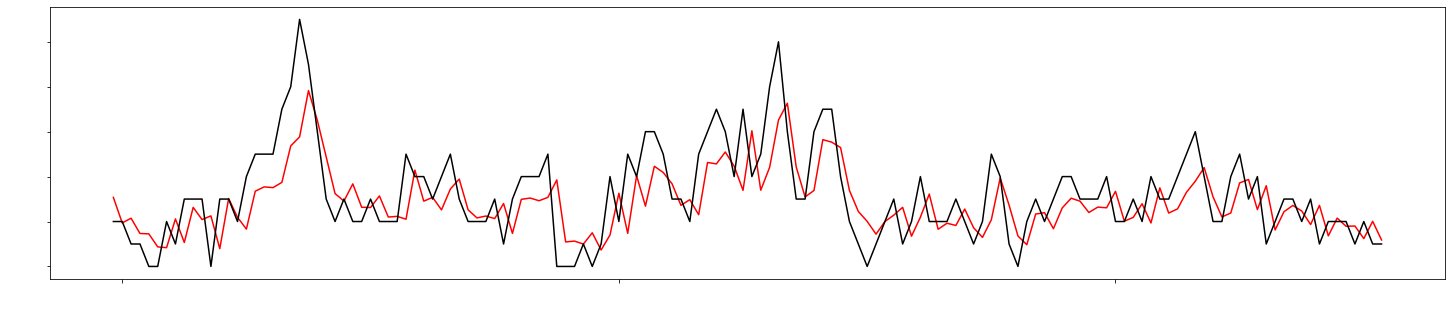

In [246]:
# Plotting predictions vs actual of best model
bat_10_predictions = pd.to_numeric(min(bat_10_lstm_grid_search_results, key=bat_10_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_10_predictions[:2*24*3],color='red')
plt.plot(bat_10_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Croston Method

In [361]:
# Combining Train and Validation for croston algorithm
bat_10_train_and_val = bat_10_train.append(bat_10_val)

In [362]:
bat_10_croston_tsb = Croston_TSB(bat_10_train_and_val)

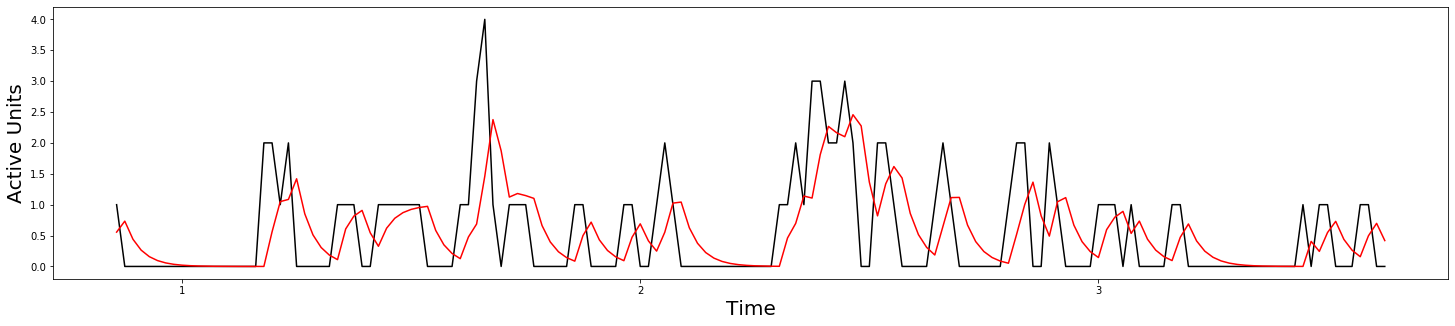

In [363]:
# Plotting predictions vs actual of croston model  (used #FFFFFF for presentation colors)

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_10_croston_tsb.iloc[12:24+(2*24*3),0],color='black')
sns.lineplot(data=bat_10_croston_tsb.iloc[12:24+(2*24*3),1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='black')
plt.yticks(color='black')
plt.xlabel('Time',fontsize = 20, color='black')
plt.ylabel('Active Units', fontsize = 20, color='black');

In [364]:
bat_10_croston_tsb.fillna(0, inplace=True)


In [365]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_10_croston_tsb.loc[:,'Demand'], bat_10_croston_tsb.loc[:,'Forecast']) )

0.7894161830133725

## Previous Work
* Keeping this for the time being until it isn't needed anymore

In [3]:
# Unpickling battalion 1 30 minute time series
redo_pickle = False

if redo_pickle == True:
    with open('bat_1_30_min.pickle','wb') as f:
        pickle.dump(bat_1_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_1_30_min.pickle','rb') as f:
        bat_1 = pickle.load(f)

In [140]:
bat_1_train, bat_1_val, bat_1_test = train_val_test_split(bat_1_unavailable_units_30_min_df['unavailable_units'])

Train: 268339
Validation: 33543
Test: 33543


In [124]:
bat_1_lstm_grid_search_results = lstm_with_grid_search(bat_1_train, bat_1_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268315/268315 [==============================] - 51s 190us/step - loss: 0.5565
Epoch 2/2
268315/268315 [==============================] - 50s 185us/step - loss: 0.5269
Test MSE: 0.834


In [96]:
# Finding model hyperparameters with lowest mse
# min(lstm_grid_search_results, key=lstm_grid_search_results.get)

In [10]:
np.sqrt(bat_1_lstm_grid_search_results[min(bat_1_lstm_grid_search_results, key=bat_1_lstm_grid_search_results.get)])

0.9113105832740133

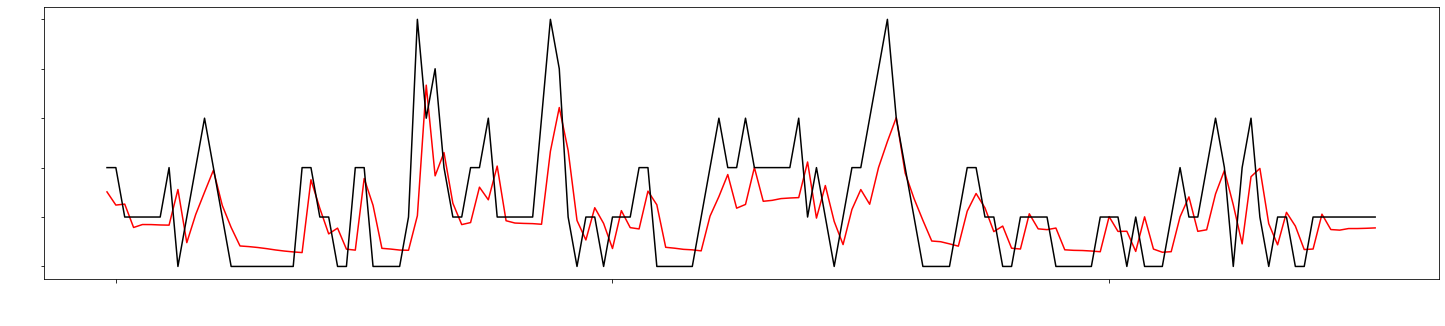

In [125]:
# Plotting predictions vs actual of best model
bat_1_predictions = pd.to_numeric(min(bat_1_lstm_grid_search_results, key=bat_1_lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(bat_1_predictions[:2*24*3],color='red')
plt.plot(bat_1_val[24:].values[:2*24*3],color='black')

plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');

### Intermittent Demand Forecasting Techniques

In [48]:
bat_1_croston = Croston(bat_1_val['unavailable_units'])

In [49]:
bat_1_croston_tsb = Croston_TSB(bat_1_val['unavailable_units'])

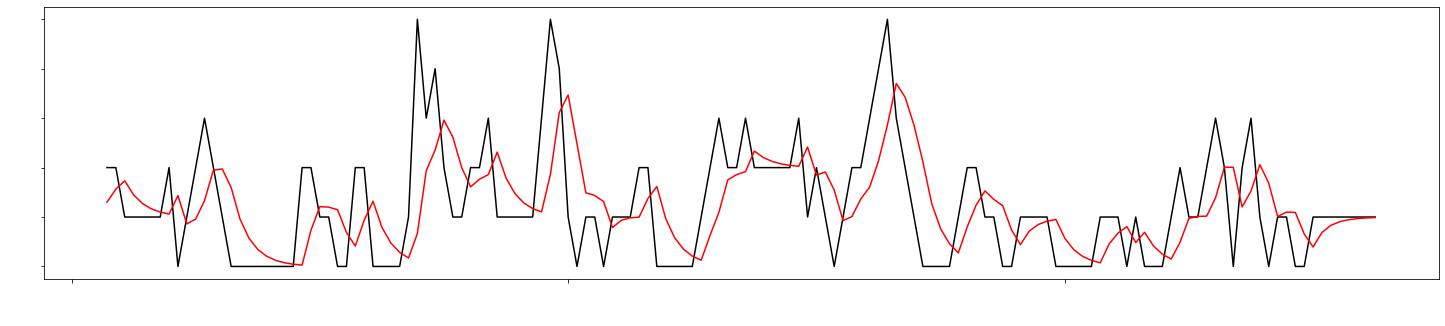

In [116]:
# Plotting predictions vs actual of croston model

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_1_croston_tsb.iloc[24:24+(2*24*3),0],color='black')
# sns.lineplot(data=bat_1_croston.iloc[:2*24*7,1]);
sns.lineplot(data=bat_1_croston_tsb.iloc[24:24+2*24*3,1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');


In [14]:
bat_1_croston_tsb.fillna(0, inplace=True)


In [15]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_1_croston.loc[:,'Demand'], bat_1_croston.loc[:,'Forecast']) )

0.9511323004580738

In [16]:
# Calculating MSE of croston
np.sqrt(mean_squared_error(bat_1_croston_tsb.loc[:,'Demand'], bat_1_croston_tsb.loc[:,'Forecast']) )

0.8182765014343473

In [17]:
# Calculating MAE of croston
np.sqrt(mean_absolute_error(bat_1_croston.loc[:,'Demand'], bat_1_croston.loc[:,'Forecast']) )

0.8783885437889961

In [18]:
# Calculating MAE of croston
np.sqrt(mean_absolute_error(bat_1_croston_tsb.loc[:,'Demand'], bat_1_croston_tsb.loc[:,'Forecast']) )

0.7743790506138304

### Battalion 2

### LSTM

In [72]:
# Pickling the battalion 2 30 minute data
redo_pickle = False

if redo_pickle == True:
    with open('bat_2_30_min.pickle','wb') as f:
        pickle.dump(bat_2_unavailable_units_30_min_df,f)
        
if redo_pickle == False:
    with open('bat_2_30_min.pickle','rb') as f:
        bat_2_unavailable_units_30_min_df = pickle.load(f)

In [76]:
bat_2 = bat_2_unavailable_units_30_min_df['unavailable_units']

In [77]:
bat_2_train, bat_2_val, bat_2_test = train_val_test_split(bat_2)

Train: 268339
Validation: 33543
Test: 33543


In [79]:
lstm_grid_search_results = lstm_with_grid_search(bat_2_train, bat_2_val)

Model with: n_steps: 24 batch_size: 128 epochs: 2
Epoch 1/2
268315/268315 [==============================] - 66s 246us/step - loss: 1.7183
Epoch 2/2
268315/268315 [==============================] - 68s 252us/step - loss: 1.6522
Test MSE: 2.817


In [96]:
# Finding model hyperparameters with lowest mse
# min(lstm_grid_search_results, key=lstm_grid_search_results.get)

In [80]:
np.sqrt(lstm_grid_search_results[min(lstm_grid_search_results, key=lstm_grid_search_results.get)])

1.6783782679217152

In [94]:
bat_2_val[24:].index[:2*24*3]

DatetimeIndex(['2015-08-02 21:30:00', '2015-08-02 22:00:00',
               '2015-08-02 22:30:00', '2015-08-02 23:00:00',
               '2015-08-02 23:30:00', '2015-08-03 00:00:00',
               '2015-08-03 00:30:00', '2015-08-03 01:00:00',
               '2015-08-03 01:30:00', '2015-08-03 02:00:00',
               ...
               '2015-08-05 16:30:00', '2015-08-05 17:00:00',
               '2015-08-05 17:30:00', '2015-08-05 18:00:00',
               '2015-08-05 18:30:00', '2015-08-05 19:00:00',
               '2015-08-05 19:30:00', '2015-08-05 20:00:00',
               '2015-08-05 20:30:00', '2015-08-05 21:00:00'],
              dtype='datetime64[ns]', length=144, freq=None)

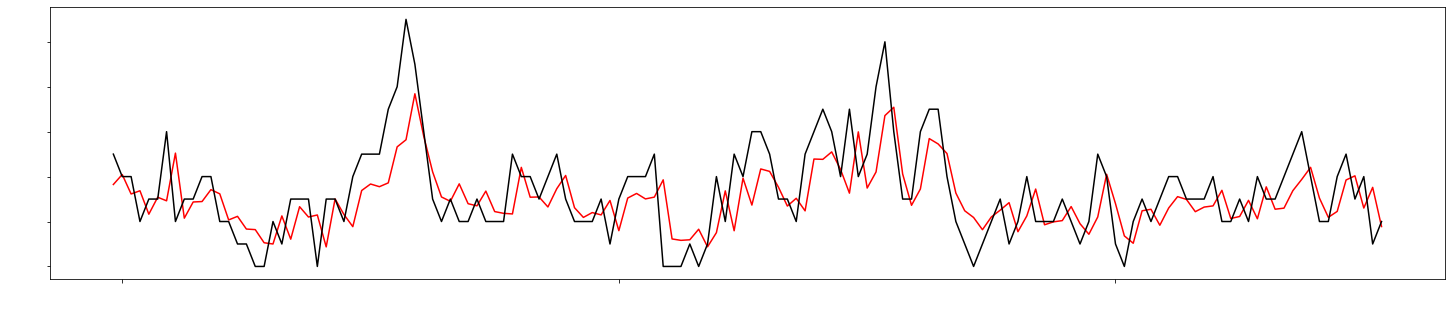

In [110]:
# Plotting predictions vs actual of best model
predictions = pd.to_numeric(min(lstm_grid_search_results, key=lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
plt.plot(predictions[:2*24*3],color='red',)
plt.plot(bat_2_val[24:].values[:2*24*3],color='black')
plt.xticks(np.arange(1,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');
# plt.title('SVC ROC Curves', fontsize = 20, color='#FFFFFF')
# plt.legend(loc="lower right", fontsize = 16);

### Croston

In [85]:
bat_2_croston = Croston(bat_2_val)

In [86]:
bat_2_croston_tsb = Croston_TSB(bat_2_val)

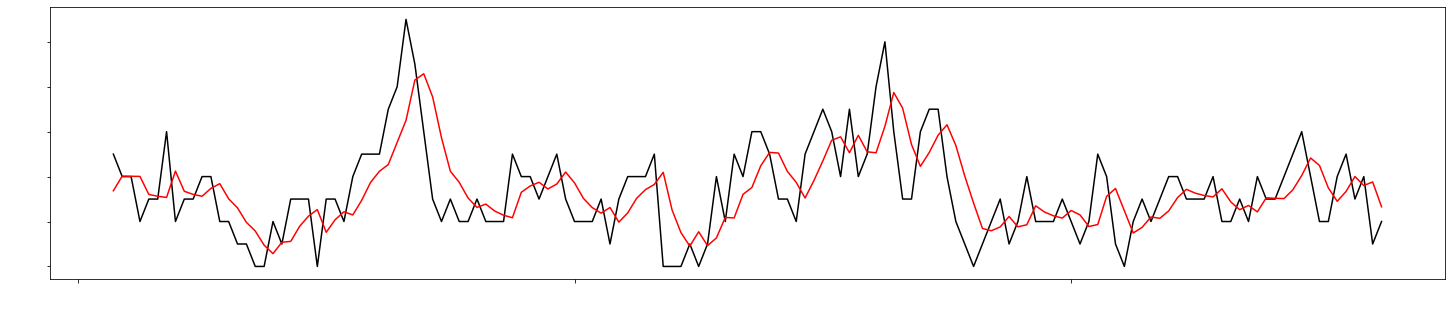

In [127]:
# Plotting predictions vs actual of croston model

plt.figure(figsize=(25,5))
sns.lineplot(data=bat_2_croston_tsb.iloc[24:24+(2*24*3),0],color='black')
# sns.lineplot(data=bat_1_croston.iloc[:2*24*7,1]);
sns.lineplot(data=bat_2_croston_tsb.iloc[24:24+2*24*3,1],color='red')
# plt.plot(range(24,168),predictions[:2*24*3],color='blue')

plt.xticks(np.arange(20,168,56), [1, 2, 3], color='#FFFFFF')
plt.yticks(color='#FFFFFF')
plt.xlabel('Time',fontsize = 20, color='#FFFFFF')
plt.ylabel('Active Units', fontsize = 20, color='#FFFFFF');


In [88]:
bat_2_croston_tsb.fillna(0, inplace=True)


In [89]:
# Calculating RMSE of croston
np.sqrt(mean_squared_error(bat_2_croston.loc[:,'Demand'], bat_2_croston.loc[:,'Forecast']) )

1.8881473328440206

In [90]:
# Calculating MSE of croston TSB
np.sqrt(mean_squared_error(bat_2_croston_tsb.loc[:,'Demand'], bat_2_croston_tsb.loc[:,'Forecast']) )

1.8466538390223524